In [66]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import pointpats
import libpysal
import geopandas

In [68]:
gdf = geopandas.read_parquet('riverside_overdose_deaths.parquet')

In [69]:
gdf.head()

,SFN,LRN,agegrp,category,epe_race,epe_race2,week,region,region2,RECSTAT,...,SSNPASS,PODZIPCODE,PODZIP4DIG,NIOSHINDCODE,NIOSHOCUCODE,DTRECLASTMOD,EXPORTDATE,geometry,points,day
912,3052022009469,3202233000545,45-64,OD-Illegal,White,White,52-2021,Mid,Mid,REG SR,...,Y,92536,NaN,NaN,NaN,2022-04-08 13:27:03,2022-04-15 08:57:22,POINT EMPTY,POINT (-116.91936 33.46661),366
569,3052021227384,3202133014958,45-64,OD-Illegal,White,White,33-2021,Mid,Mid,REG SR,...,Y,92544,NaN,8590.0,1010.0,2021-10-22 13:04:08,2022-03-29 11:56:49,POINT EMPTY,POINT (-116.86691 33.51497),229
938,3052022047309,3202233003169,45-64,OD-Illegal,Hispanic,Hispanic,02-2022,Mid,Mid,REG SR,...,Y,92544,NaN,NaN,NaN,2022-04-08 13:27:03,2022-04-15 08:57:22,POINT EMPTY,POINT (-116.89557 33.53169),374
440,3052021179531,3202133011868,45-64,OD-Illegal,White,White,27-2021,None,None,REG SR,...,None,None,NaN,770.0,220.0,2021-09-03 09:03:05,2022-03-29 11:56:49,POINT EMPTY,POINT (-116.92185 33.55339),188
576,3052021236736,3202133015570,45-64,OD-Illegal,White,White,33-2021,Mid,Mid,REG SR,...,Y,92544,NaN,NaN,NaN,2021-10-22 13:02:40,2022-03-29 11:56:49,POINT EMPTY,POINT (-116.90634 33.61339),233


In [70]:
gdf = gdf.to_crs(gdf.estimate_utm_crs())

## Refactoring

### Alterantive 1
```
st = Knox(scoords, tcoords) # builds trees on init

st.fit(delta=1000, tau=7) # query the trees to calculate space-time neighbors given thresholds with analytic inference (global and local)

st.transform(crit=0.01) # identify hotspots with crit at 0.01 with analytical inference only with delta and tau set from the previous fit

st.transform(crit=0.01, permutations=99) # identify hotspots with crit at 0.01 with analytical and permutation inference with delta and tau set from the previous fit

st.fit_transform(delta=1000, tau=7, crit=0.01, permutations=99) # all at once
```

### Alternative 2
```
st = Knox(scoords, tcoords)

st.fit(delta=1000, tau=7) # queries the tree

st.hot_spots(crit=0.5)  # could be used to filter pvalues

st.fit(delta=500, tau=14).hot_spots(crit=0.01)  # refit and refilter

```

### Alternative 3
```
st = Knox()
st.fit(scoords, tcoords) # builds tree
st.transform(delta=1000, tau=14, permutations=0) # builds two graphs and identifies neighbors and inference (analytical only if permutations=0)
st.hot_spots(crit=0.05) # identifies local hot-spots

```

## Considerations

- KnoxLocal versus  Knox
  - global calcs come along for the ride
  - local only calculated when KnoxLocal is instantiated
  - st.fit(scoords, tcoords)
 
  - or maybe we don't have a local class, but hot_spots method on Knox does local inference?
- handling of spatially coincident points in visualization
- 
- optimizing inference calculations


import scipy as sp
import networkx as nx
from functools import cached_property
from scipy.stats import poisson, hypergeom
import geopandas as gpd


class Knox_Transformer:
    def __init__(self, s_tree, t_tree, delta, tau, p=2):

        # get temporal neighbors and build t-graph
        edges = sorted(t_tree.query_pairs(tau, p=p))
        self.tau = tau
        self.t_graph = nx.Graph()
        self.t_graph.add_edges_from(edges)

        # get spatial neighbors and build s-graph
        edges = sorted(s_tree.query_pairs(delta, p=2))
        self.delta = delta
        self.s_graph = nx.Graph()
        self.s_graph.add_edges_from(edges)

    @cached_property
    def st_graph(self):
        return nx.intersection(self.s_graph, self.t_graph)

    @cached_property
    def n(self):
        return len(self.t_graph.nodes)
        
    @cached_property
    def nst(self):
        return len(self.st_graph.edges)

    @cached_property
    def nt(self):
        return len(self.t_graph.edges)

    @cached_property
    def ns(self):
        return len(self.s_graph.edges)
 
    @cached_property
    def enst(self):
        return (self.ns * self.nt) / (self.n * (self.n - 1) / 2)

    @cached_property
    def p_value_poisson(self):
        return 1 - poisson.cdf(self.nst, self.enst)

    @cached_property
    def st_adj(self):
        return nx.to_pandas_edgelist(self.st_graph.to_directed())

    @cached_property
    def s_adj(self):
        return nx.to_pandas_edgelist(self.s_graph.to_directed())

    @cached_property
    def t_adj(self):
        return nx.to_pandas_edgelist(self.t_graph.to_directed())


    def cardinalities(self, adj):
        _cards = np.zeros(self.n)
        counts = adj.groupby(by='source').count()
        _cards[counts.index]=counts.target
        return _cards
                                     
    @cached_property
    def nsti(self):  # number of space-time neighbors for each unit
        return self.cardinalities(self.st_adj)

    @cached_property
    def nsi(self):  # number of spatial neighbors for each unit
        return self.cardinalities(self.s_adj)

    @cached_property
    def nti(self): # number of temporal neighbors for each unit
        return self.cardinalities(self.t_adj)


    @cached_property
    def hg_pvalues(self):
        n1 = self.n - 1
        p = [ 1 - hypergeom.cdf(self.nsti[i] - 1, n1, self.nti, self.nsi[i]).mean() for i in range(self.n)]
        return np.array(p)
            


class Knox:
    def __init__(self):
        self.name ='knox'
        
    def fit(self, scoords, tcoords):
        # build trees
        self.t_tree = sp.spatial.cKDTree(tcoords)
        self.s_tree = sp.spatial.cKDTree(scoords)
        self.scoords = scoords
        self.tcoords = tcoords

    def transform(self, delta, tau,  p=2):
        # build graphs based on tree queries 
        self.transformer = Knox_Transformer(self.s_tree, self.t_tree, delta, tau, p=p)

    def hot_spots(self, crit=0.05):
        self.hg_pvalues = self.transformer.hg_pvalues
        return np.where(self.hg_pvalues <= crit)[0]


        

    @property
    def _gdf(self):
        geom = gpd.points_from_xy(self.scoords[:,0], self.scoords[:,1])
        gdf = gpd.GeoDataFrame(geometry=geom)
        gdf['t_coords'] = self.tcoords
        gdf['p_hypergeom'] = self.transformer.hg_pvalues
        return gdf

    def plot(self,
             kind="all",
             colors={"focal": "red", "neighbor": "blue", "nonsig": "grey"},
             crit=0.05,
             inference="permutation",
            ):

        hs = self.hot_spots(crit=crit)
        g = self._gdf.copy()
        g['color'] = colors['nonsig']
        g['pvalue'] = g.p_hypergeom
        mask = g[g.pvalue <= crit].index.values
        adj = self.transformer.st_adj
        neighbors = adj[adj.source.isin(mask)].target.unique()
        g.loc[neighbors, 'color'] = colors['neighbor']
        g.loc[mask, "color"] = colors['focal']
        m = g[g.color == colors['nonsig']].plot(color=colors['nonsig'])
        g[g.color == colors["neighbor"]].plot(ax=m, color=colors['neighbor'])
        g[g.color == colors["focal"]].plot(ax=m, color=colors["focal"])
        return m


    def explore(self,
                colors={"focal": "red", "neighbor": "blue", "nonsig": "grey"},
                crit=0.05,
                inference="permutation",
                crs=None
            ):
                
        hs = self.hot_spots(crit=crit)
        g = self._gdf.copy()
        g.crs = crs
        g['color'] = colors['nonsig']
        g['pvalue'] = g.p_hypergeom
        mask = g[g.pvalue <= crit].index.values
        adj = self.transformer.st_adj
        neighbors = adj[adj.source.isin(mask)].target.unique()
        g.loc[neighbors, 'color'] = colors['neighbor']
        g.loc[mask, "color"] = colors['focal']
        m = g[g.color == colors['nonsig']].explore(color=colors['nonsig'])
        g[g.color == colors["neighbor"]].explore(m=m, color=colors['neighbor'])
        g[g.color == colors["focal"]].explore(m=m, color=colors["focal"])
        return m     
                
                
        

In [86]:
import numpy as np
np.random.seed(12345)

from pointpats.spacetime import KnoxSingle
st = KnoxSingle()


In [87]:
scoords = np.stack([gdf.points.x, gdf.points.y], axis=1)

tcoords = np.vstack(gdf.day.values)

In [88]:
st.fit(scoords, tcoords)

In [89]:
st.transform(delta=1000, tau=7)

In [90]:
st.hot_spots()

array([217, 366, 368, 447, 606, 607, 650, 677])

In [91]:
st.transformer.nst

29

<Axes: >

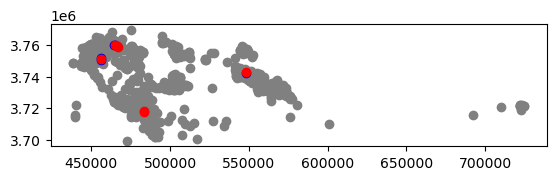

In [92]:
st.plot()

In [81]:
st._gdf.tail()

,geometry,t_coords,p_hypergeom
700,POINT (463086.512 3763291.217),222,1.000000
701,POINT (469695.297 3764176.730),30,1.000000
702,POINT (454741.228 3764310.107),299,0.070442
703,POINT (455253.406 3764508.699),288,1.000000
704,POINT (453039.654 3765407.053),87,1.000000


In [82]:
st.explore(crs=gdf.crs)

In [83]:
st.transform(delta=1000, tau=14)

In [84]:
st.hot_spots()

array([ 47, 673, 691, 702, 703])

In [85]:
st.explore(crs=gdf.crs)

In [25]:
st.transform(delta=1000, tau=28)

In [26]:
st.hot_spots()

array([191, 691, 702, 703])

In [23]:
st.explore(crs=gdf.crs)

In [27]:
st.hot_spots()

array([191, 691, 702, 703])

In [28]:
st.transformer.st_adj[st.transformer.st_adj.source.isin(st.hot_spots())]

,source,target
51,191,205
52,191,207
53,191,187
175,691,703
176,691,702
178,702,691
179,702,703
180,703,691
181,703,702


In [29]:
st.transformer.st_adj[st.transformer.st_adj.source.isin(st.hot_spots(crit=0.04))]

,source,target
51,191,205
52,191,207
53,191,187
175,691,703
176,691,702
178,702,691
179,702,703
180,703,691
181,703,702


In [160]:
import libpysal
pth = libpysal.examples.get_path("burkitt.shp")

In [161]:
gdf = geopandas.read_file(pth)

In [162]:
stb = pointpats.spacetime.KnoxSingle()
#(gdf[["X", "Y"]], gdf[["T"]], delta=20, tau=5)

In [179]:
stb.fit(gdf[['X', 'Y']].values, gdf[["T"]].values)

In [180]:
stb.transform(delta=20, tau=5)

In [181]:
stb.scoords

array([[300., 302.],
       [291., 270.],
       [326., 263.],
       [299., 376.],
       [267., 327.],
       [266., 356.],
       [267., 345.],
       [262., 338.],
       [268., 335.],
       [335., 275.],
       [302., 272.],
       [301., 304.],
       [302., 272.],
       [324., 337.],
       [260., 338.],
       [306., 385.],
       [284., 362.],
       [293., 332.],
       [274., 353.],
       [263., 333.],
       [307., 386.],
       [274., 357.],
       [297., 282.],
       [288., 365.],
       [283., 366.],
       [290., 352.],
       [284., 341.],
       [286., 341.],
       [282., 350.],
       [292., 278.],
       [305., 381.],
       [298., 378.],
       [299., 381.],
       [287., 342.],
       [276., 380.],
       [261., 345.],
       [273., 347.],
       [284., 357.],
       [266., 361.],
       [285., 360.],
       [278., 350.],
       [305., 321.],
       [293., 332.],
       [297., 375.],
       [332., 273.],
       [256., 345.],
       [275., 357.],
       [267.,

In [182]:
stb.tcoords

array([[ 413.],
       [ 472.],
       [ 511.],
       [ 689.],
       [ 730.],
       [ 847.],
       [ 871.],
       [ 899.],
       [ 921.],
       [1134.],
       [1190.],
       [1214.],
       [1224.],
       [1322.],
       [1399.],
       [1480.],
       [1503.],
       [1549.],
       [1567.],
       [1607.],
       [1615.],
       [1657.],
       [1688.],
       [1695.],
       [1714.],
       [1811.],
       [1813.],
       [1910.],
       [1986.],
       [1996.],
       [2049.],
       [2053.],
       [2075.],
       [2081.],
       [2103.],
       [2204.],
       [2209.],
       [2215.],
       [2239.],
       [2272.],
       [2281.],
       [2349.],
       [2351.],
       [2373.],
       [2377.],
       [2388.],
       [2411.],
       [2412.],
       [2419.],
       [2424.],
       [2488.],
       [2510.],
       [2512.],
       [2533.],
       [2545.],
       [2588.],
       [2616.],
       [2617.],
       [2629.],
       [2658.],
       [2695.],
       [2715.],
       [

In [183]:
stb.transformer.nst

10

In [184]:
stb.transformer.st_adj

,source,target
0,137,138
1,138,137
2,139,140
3,140,139
4,30,31
5,31,30
6,158,159
7,159,158
8,35,36
9,36,35


In [185]:
stb.transformer.n

188

In [186]:
stb.transformer.nsti

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [187]:
gdf.shape

(188, 7)

In [188]:
stb.transformer.t_graph.nodes

NodeView((25, 26, 30, 31, 35, 36, 41, 42, 43, 44, 46, 47, 48, 49, 51, 52, 56, 57, 69, 70, 71, 81, 82, 84, 85, 98, 99, 100, 101, 102, 103, 107, 108, 113, 114, 115, 116, 117, 118, 119, 122, 123, 125, 126, 128, 129, 137, 138, 139, 140, 141, 143, 144, 150, 151, 152, 153, 154, 155, 156, 158, 159, 162, 163, 167, 168, 169, 174, 175, 176, 178, 179, 184, 185, 186))

In [189]:
stb.t_tree.n

188

In [190]:
stb.transformer.p_value_poisson

0.4349469351009174

In [191]:
stb.hot_spots()

array([ 41,  42, 118])

<Axes: >

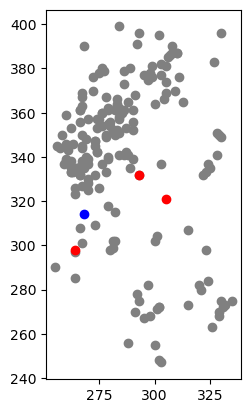

In [192]:
stb.plot()